In [1]:
# https://github.com/lu-group/gpinn
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
        self.init_bias()
    def forward(self,x):
        x=self.net(x)
        return x
    def init_bias(self):
        for layer in self.net.children():
            if isinstance(layer, nn.Linear):
                # 权重采用Xavier正态初始化
                nn.init.xavier_normal_(layer.weight, gain=5 / 3)
                # 偏置置0
                nn.init.constant_(layer.bias, 0.)

In [3]:
def u_function(x):
    u = model(x)
    return u

def f_function(x):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    return u_xx + torch.sin(x) + 2 * torch.sin(2*x) + 3 * torch.sin(3*x) + 4 * torch.sin(4*x) + 8 * torch.sin(8*x)

def Loss(x_f):
    f_pre = f_function(x_f)
    null =  torch.zeros((x_f.shape[0], 1))
    f_loss = loss_fn(f_pre, null)
    
    u_0 = u_function(torch.tensor(0,dtype=torch.float32).reshape(-1,1))
    u_pi = u_function(torch.tensor(torch.pi,dtype=torch.float32).reshape(-1,1))
    x_u = torch.cat([u_0,u_pi],0)
    null = torch.tensor([0,torch.pi],dtype=torch.float32).reshape(-1,1)
    u_loss = loss_fn(x_u,null)
    ls = f_loss + u_loss
    ls.backward()
    return ls

[Epoch 1/2000] [loss: 51.842098236083984]
[Epoch 101/2000] [loss: 11.45237922668457]
[Epoch 201/2000] [loss: 10.235299110412598]
[Epoch 301/2000] [loss: 1.7567706108093262]
[Epoch 401/2000] [loss: 1.3064519166946411]
[Epoch 501/2000] [loss: 0.007592923939228058]
[Epoch 601/2000] [loss: 0.004217501729726791]
[Epoch 701/2000] [loss: 0.0030779268126934767]
[Epoch 801/2000] [loss: 0.002394914859905839]
[Epoch 901/2000] [loss: 0.0019327945774421096]
[Epoch 1001/2000] [loss: 0.0016013254644349217]
[Epoch 1101/2000] [loss: 0.0013557105557993054]
[Epoch 1201/2000] [loss: 0.0011698435992002487]
[Epoch 1301/2000] [loss: 0.0010269981576129794]
[Epoch 1401/2000] [loss: 0.0009158316534012556]
[Epoch 1501/2000] [loss: 0.000828368472866714]
[Epoch 1601/2000] [loss: 0.0007587968721054494]
[Epoch 1701/2000] [loss: 0.0007029131520539522]
[Epoch 1801/2000] [loss: 0.0006575814913958311]
[Epoch 1901/2000] [loss: 0.0006204616511240602]


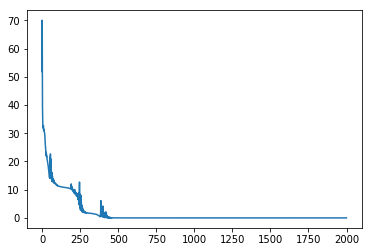

In [4]:
# 制造数据点集
N_u = 100
N_f = 10000
x_f = np.random.rand(N_f, 1) * np.pi
x_f = torch.tensor(x_f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=False) # 动态递减学习率
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = Loss(x_f)
    Losses.append(loss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

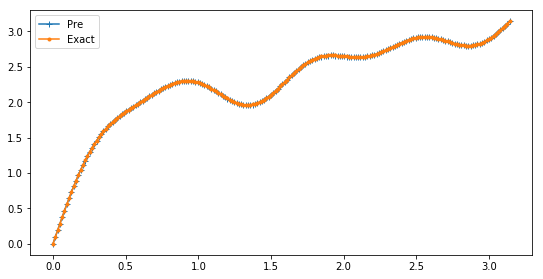

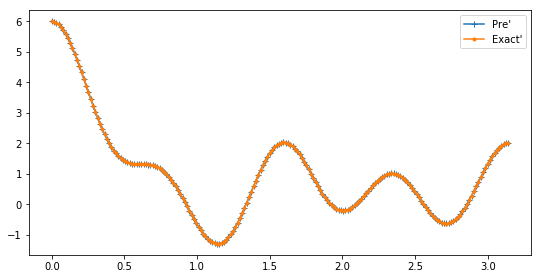

In [7]:
# 可视化
def Exact_f(x):
    f = x + torch.sin(x) + torch.sin(2*x) / 2 + torch.sin(3*x) / 3 + torch.sin(4*x) / 4 + torch.sin(8*x) / 8
    return f

x = torch.linspace(0, np.pi, 200, dtype=torch.float32).reshape(-1,1).requires_grad_()
u_pre = u_function(x).reshape(-1,1)
u_exact = Exact_f(x)
xnp = x.detach().numpy()
Unp = u_pre.detach().numpy()
Uex = u_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Unp,marker='+',label='Pre')
plt.plot(xnp,Uex,marker='.',label='Exact')
plt.legend()
plt.show()
ux_pre = torch.autograd.grad(u_pre, x, torch.ones_like(u_pre), retain_graph=True, create_graph=True)[0]
ux_exact = torch.autograd.grad(Exact_f(x), x, torch.ones_like(Exact_f(x)), retain_graph=True, create_graph=True)[0]
Uxnp = ux_pre.detach().numpy()
Uxex = ux_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Uxnp,marker='+',label='Pre\'')
plt.plot(xnp,Uxex,marker='.',label='Exact\'')
plt.legend()
plt.show()

[Epoch 1/2000] [loss: 116.06451416015625]
[Epoch 101/2000] [loss: 20.841093063354492]
[Epoch 201/2000] [loss: 0.18335774540901184]
[Epoch 301/2000] [loss: 0.09708914160728455]
[Epoch 401/2000] [loss: 0.04390629008412361]
[Epoch 501/2000] [loss: 0.45056387782096863]
[Epoch 601/2000] [loss: 0.00849162321537733]
[Epoch 701/2000] [loss: 0.00407014787197113]
[Epoch 801/2000] [loss: 0.0025153914466500282]
[Epoch 901/2000] [loss: 0.001850408734753728]
[Epoch 1001/2000] [loss: 0.0015204576775431633]
[Epoch 1101/2000] [loss: 0.0013293968513607979]
[Epoch 1201/2000] [loss: 0.0012012728257104754]
[Epoch 1301/2000] [loss: 0.0011054534697905183]
[Epoch 1401/2000] [loss: 0.0010288142366334796]
[Epoch 1501/2000] [loss: 0.0009650837164372206]
[Epoch 1601/2000] [loss: 0.0009109117672778666]
[Epoch 1701/2000] [loss: 0.0008642100146971643]
[Epoch 1801/2000] [loss: 0.0008235354325734079]
[Epoch 1901/2000] [loss: 0.0007878716569393873]


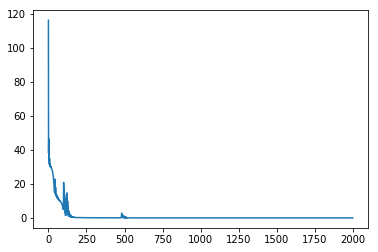

In [3]:
def u_function(x):
    u = model(x)
    u = x * (torch.pi - x) * u + x
    return u
def f_function(x):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    return u_xx + torch.sin(x) + 2 * torch.sin(2*x) + 3 * torch.sin(3*x) + 4 * torch.sin(4*x) + 8 * torch.sin(8*x)
def LossFree(x_f):
    f_pre = f_function(x_f)
    null =  torch.zeros((x_f.shape[0], 1))
    f_loss = loss_fn(f_pre, null)
    ls = f_loss
    ls.backward()
    return ls
# 制造数据点集
N_f = 10000
x_f = np.random.rand(N_f, 1) * np.pi
x_f = torch.tensor(x_f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=False) # 动态递减学习率
epochs = 2000
Losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = LossFree(x_f)
    Losses.append(loss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

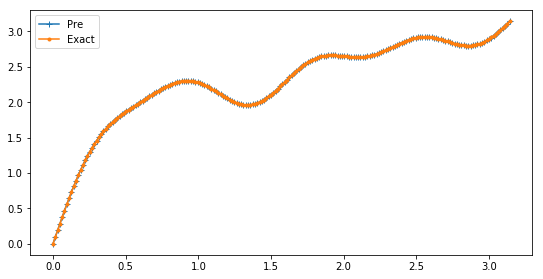

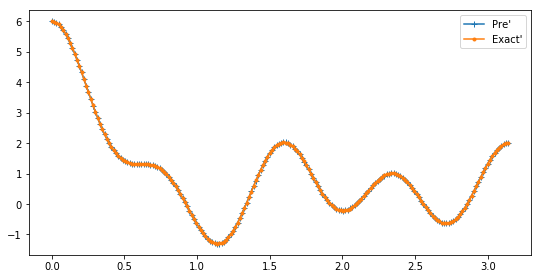

In [7]:
# 可视化
def Exact_f(x):
    f = x + torch.sin(x) + torch.sin(2*x) / 2 + torch.sin(3*x) / 3 + torch.sin(4*x) / 4 + torch.sin(8*x) / 8
    return f

x = torch.linspace(0, np.pi, 200, dtype=torch.float32).reshape(-1,1).requires_grad_()
u_pre = u_function(x).reshape(-1,1)
u_exact = Exact_f(x)
xnp = x.detach().numpy()
Unp = u_pre.detach().numpy()
Uex = u_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Unp,marker='+',label='Pre')
plt.plot(xnp,Uex,marker='.',label='Exact')
plt.legend()
plt.show()
ux_pre = torch.autograd.grad(u_pre, x, torch.ones_like(u_pre), retain_graph=True, create_graph=True)[0]
ux_exact = torch.autograd.grad(Exact_f(x), x, torch.ones_like(Exact_f(x)), retain_graph=True, create_graph=True)[0]
Uxnp = ux_pre.detach().numpy()
Uxex = ux_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Uxnp,marker='+',label='Pre\'')
plt.plot(xnp,Uxex,marker='.',label='Exact\'')
plt.legend()
plt.show()